In [1]:
from libraries import *

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-04-24 08:26:02 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
from models import asr_model, spec_gen, vocoder
from transfer_modules import *

[NeMo E 2022-04-24 08:26:04 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69e84afbb0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-04-24 08:26:05 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69c4db6610>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-04-24 08:26:07 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69bb651550>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might res

In [3]:
from datetime import datetime


In [4]:
models = [asr_model, spec_gen, vocoder]

asr_model.cuda()
spec_gen.cuda()
vocoder.cuda(1)

# for model in models:
#     model.cuda()

HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0

In [6]:
max_epochs = 1000
dataloader_idx = 0
overall_loss = []
validate_asr = True
validate_spec_gen = True

In [7]:
on_train_start(models)

In [1]:
res = []
wer = []
spec_gen_loss = []

dt = True

# progress_bar = tqdm(range(int(10e6)))

for epoch in range(max_epochs + 1):
#     print('epoch start', epoch)
    epoch_loss = []
    
    on_epoch_start(models)
    
#     if epoch > 80:
#         dt = True
    
    for batch_idx, (asr_batch, tts_batch, raw_signal_batch, raw_text_batch) in \
       tqdm(enumerate(zip(asr_model.train_dataloader(), spec_gen.train_dataloader(), 
                     asr_model.val_dataloader(), spec_gen.val_dataloader()))):
                
        asr_loss, fastpitch_loss, hifigan_loss = 0, 0, 0
                            
        asr_loss = asr_training_step(
            asr_model, spec_gen, vocoder, asr_batch, raw_signal_batch, batch_idx, epoch=epoch, dt=dt)
        
        fastpitch_loss, hifigan_loss = tts_training_step(
            asr_model, spec_gen, vocoder, tts_batch, raw_signal_batch, batch_idx, epoch=epoch, dt=dt)
        
#     print(asr_loss, fastpitch_loss, hifigan_loss, datetime.now())
        
        epoch_loss.append([asr_loss, fastpitch_loss, hifigan_loss])
    
    on_epoch_end(models)
    epoch_loss = np.array(epoch_loss)
    res.append([epoch, np.mean(epoch_loss[:, 0]), np.mean(epoch_loss[:, 1]), np.mean(epoch_loss[:, 2])])
    
    if validate_asr and (epoch % 5 == 0):
        train_wer = asr_val(asr_model, asr_model.train_dataloader())
        val_wer = asr_val(asr_model, asr_model.val_dataloader())
        wer.append([epoch, train_wer, val_wer])
        print(epoch, 'wer', train_wer, val_wer, datetime.now())
    
    if validate_spec_gen and (epoch % 5 == 0):
        spec_gen_train_loss = tts_val(spec_gen, spec_gen.train_dataloader())
        spec_gen_val_loss = tts_val(spec_gen, spec_gen.val_dataloader())
        spec_gen_loss.append([epoch, spec_gen_train_loss, spec_gen_val_loss])
        print(epoch, 'spec_gen loss', spec_gen_train_loss, spec_gen_val_loss, datetime.now())
    
    print(epoch, 'loss', np.mean(epoch_loss[:, 0]), np.mean(epoch_loss[:, 1]), np.mean(epoch_loss[:, 2]))
    
    
on_train_end(models)

In [18]:
from datetime import datetime

print(datetime.now())

2022-04-03 17:55:39.647139


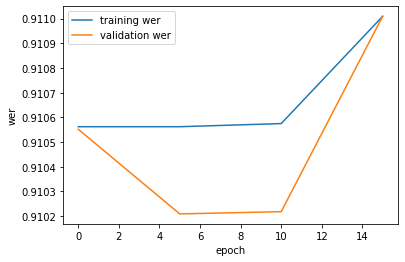

In [8]:
epoch = []
train_wer = []
val_wer = []

for item in wer:
    epoch.append(item[0])
    train_wer.append(item[1])
    val_wer.append(item[2])
    
plt.plot(epoch, train_wer, label='training wer')
plt.plot(epoch, val_wer, label='validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

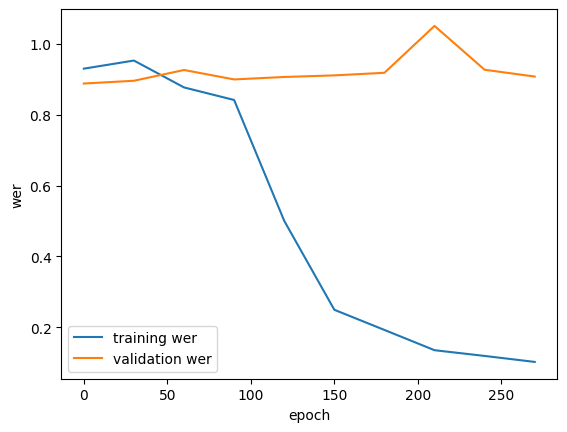

In [30]:
epoch2 = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
train_wer2 = [0.9302, 0.9531, 0.8772, 0.8417, 0.5004, 0.2492, 0.1922, 0.1350, 0.1188, 0.1019]
val_wer2 = [0.8882, 0.8960, 0.9264, 0.8998, 0.9067, 0.9112, 0.9185, 1.0509, 0.9271, 0.9079]
    
plt.plot(epoch2, train_wer2, label='training wer')
plt.plot(epoch2, val_wer2, label='validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

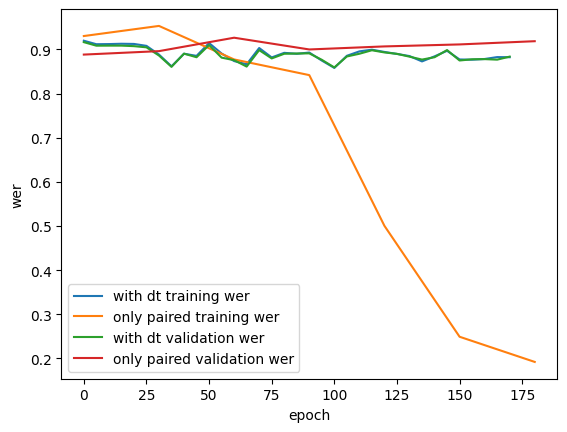

In [33]:
epoch2 = [0, 30, 60, 90, 120, 150, 180]
train_wer2 = [0.9302, 0.9531, 0.8772, 0.8417, 0.5004, 0.2492, 0.1922]
val_wer2 = [0.8882, 0.8960, 0.9264, 0.8998, 0.9067, 0.9112, 0.9185]

plt.plot(epoch, train_wer, label='with dt training wer')
plt.plot(epoch2, train_wer2, label='only paired training wer')
plt.plot(epoch, val_wer, label='with dt validation wer')
plt.plot(epoch2, val_wer2, label='only paired validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

In [11]:
vocoder = HifiGanModel.from_pretrained("tts_hifigan")

In [12]:
vocoder.cuda(1)

HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0

In [12]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

spectrogram, audio = infer(spec_gen.cuda(1), vocoder, 'Hello')

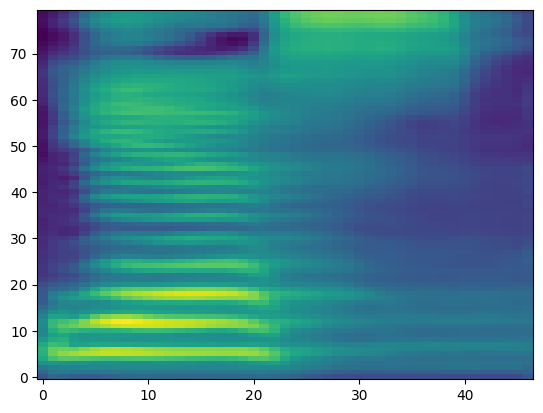

In [8]:
spectrogram = spec_gen.generate_spectrogram(tokens=parsed.cuda(), speaker=0)

imshow(spectrogram.cpu().detach().numpy()[0], origin="lower", aspect = "auto")

plt.show()